<a href="https://colab.research.google.com/github/ckoven/idealized_emissionsdriven_cdr_scenario/blob/main/Charlie_blip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import stuff

In [1]:
!pip install fair
import fair

In [2]:
import numpy as np
from scipy import stats
from fair.tools.ensemble import tcrecs_generate

from matplotlib import pyplot as plt
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (16, 9)

import xarray as xr

In [3]:
from fair.RCPs import rcp3pd, rcp45, rcp6, rcp85
from fair.SSPs import ssp370, ssp126, ssp585, ssp119
from fair.temperature.millar import calculate_q
from fair.inverse import inverse_fair_scm


In [4]:
c_1pct=fair.RCPs.rcp45.Concentrations.co2

# Define functions to return climate response parameters

In [5]:
def calc_ecs(q):
  ecs=3.72*np.sum(q)
  return ecs

In [6]:
def calc_tcr(q,d):
  tcp=q*0
  for i,m in enumerate(q):
    tcp[i]=3.72*(q[i]*(1-d[i]/70*(1-np.exp(-70/d[i]))))
  tcr=np.sum(tcp)
  return tcr

In [7]:
def get_4x(r0=35,rc=0.019,rt=4.165,tcrecs=np.array([1.75,3]),tau = np.array([1e6, 400.0, 100.0, 5.0]),a   = np.ones(4) * 0.25,iirf_h=100,d=np.array([239,4.1]),q=np.array([0.6,0.4])):
    nt = 3000 # years
    qm= np.repeat(q[np.newaxis,:],nt,axis=0)
    C  = 278. * 2**np.ones(nt) # compound 1% increase in CO2 concentrations
    C2,F2,T2 = fair.forward.fair_scm(
    emissions_driven=False,
    C=C,
    useMultigas=False,r0=r0,rc=rc,rt=rt,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm)

    return C2,F2,T2

In [8]:
def get_frdln(r0=35,rc=0.019,rt=4.165,tcrecs=np.array([1.75,3]),tau = np.array([1e6, 400.0, 100.0, 5.0]),a   = np.ones(4) * 0.25,iirf_h=100,d=np.array([239,4.1]),q=np.array([0.6,0.4])):
    nt = 140 # years
    qm= np.repeat(q[np.newaxis,:],nt,axis=0)
    C  = 278. * 1.01**np.arange(nt) # compound 1% increase in CO2 concentrations
    # run with default carbon cycle parameters
    E, F, T = inverse_fair_scm(C=C,r0=r0,rc=rc,rt=rt,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm)
    E_noc, F_noc, T_noc = inverse_fair_scm(C=C,r0=r0,rc=0,rt=rt,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm)
    E_not, F_not, T_not = inverse_fair_scm(C=C,r0=r0,rc=rc,rt=0,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm)
    beta=(np.sum(E[:70])-np.sum(E_noc[:70]))/(C[70]-C[0])
    gamma=(np.sum(E[:70])-np.sum(E_noc[:70]))/(T[70]-T[0])
    return beta,gamma
   

In [9]:
def charlie_blip(r0=35,rc=0.019,rt=4.165,tcrecs=np.array([1.75,3]),tau = np.array([1e6, 400.0, 100.0, 5.0]),a   = np.ones(4) * 0.25,iirf_h=100,d=np.array([239,4.1]),q=np.array([0.6,0.4]),tb=45,ta=1000, tpeak_fact=3.33333):
    nt=3000
    
    if tpeak_fact > 0:
        tpeak = tb*tpeak_fact
    else:
        tpeak = -tpeak_fact

    time = np.arange(0,nt)
    emms = (ta*(tpeak-time)*np.exp(-((tpeak-time)**2.)/(2*tb**2.)))/(tb**2.)
    #emms=ta*2*(-(np.arange(0,nt)-(tpeak)))/np.square(tb)*np.exp(-(np.square((np.arange(0,nt)-(tpeak))/tb)))

    emms[int(tpeak*2):] = 0.

    
    qm= np.repeat(q[np.newaxis,:],nt,axis=0)
    
    C,F,T=fair.forward.fair_scm(emissions=emms,useMultigas=False,r0=r0,rc=rc,rt=rt,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm)


    return C,F,T,emms

(0.0, 400.0)

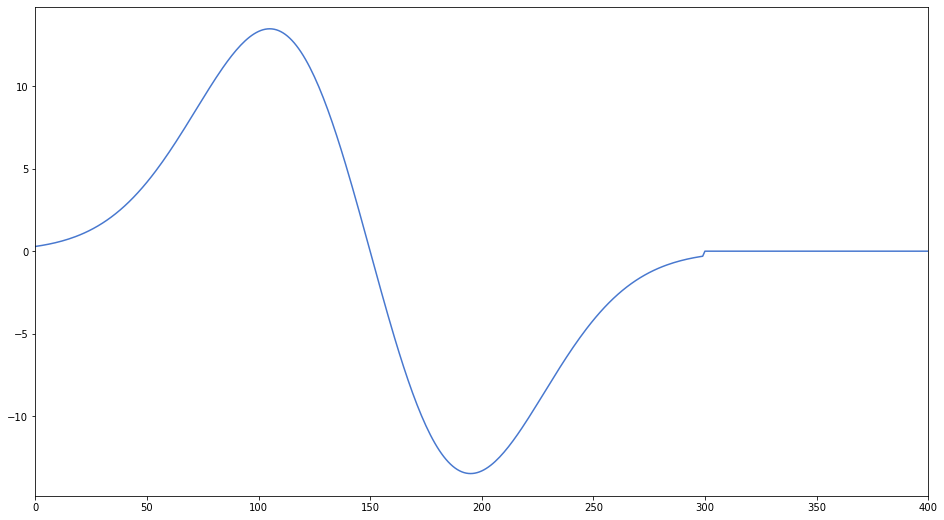

In [10]:


_,_,_,emms=charlie_blip(tb=45,tpeak_fact=-150)
plt.plot(emms)
plt.xlim(0,400)

In [11]:
def get_cdr(r0=35,rc=0.019,rt=4.165,tcrecs=np.array([1.75,3]),tau = np.array([1e6, 400.0, 100.0, 5.0]),a   = np.ones(4) * 0.25,iirf_h=100,d=np.array([239,4.1]),q=np.array([0.6,0.4])):
    nt = 70 # years
    qm= np.repeat(q[np.newaxis,:],nt,axis=0)
    C1  = 278. * 1.01**np.arange(nt) # compound 1% increase in CO2 concentrations
    # run with default carbon cycle parameters
    E1, F1, T1,restart = inverse_fair_scm(C=C1,r0=r0,rc=rc,rt=rt,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm,restart_out = True)
    #emms=np.zeros((280))
    #emms[:140]=E1
    #qm= np.repeat(q[np.newaxis,:],nt*2,axis=0)
    C2=np.flipud(C1)
    E2, F2, T2 = inverse_fair_scm(C=C2,r0=r0,rc=rc,rt=rt,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm,restart_in  = restart)
    
    C=np.concatenate((C1,C2))
    F=np.concatenate((F1,F2))
    T=np.concatenate((T1,T2))
    emms=np.concatenate((E1,E2))
   



    return C,F,T,emms

In [12]:
def get_zec(r0=35,rc=0.019,rt=4.165,tcrecs=np.array([1.75,3]),tau = np.array([1e6, 400.0, 100.0, 5.0]),a   = np.ones(4) * 0.25,iirf_h=100,d=np.array([239,4.1]),q=np.array([0.6,0.4])):
    nt = 70 # years
    qm= np.repeat(q[np.newaxis,:],nt,axis=0)
    C  = 278. * 1.01**np.arange(nt) # compound 1% increase in CO2 concentrations
    # run with default carbon cycle parameters
    E1, F1, T1 = inverse_fair_scm(C=C,r0=r0,rc=rc,rt=rt,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm)
    emms=np.zeros((nt+100))
    emms[:nt]=E1
    qm= np.repeat(q[np.newaxis,:],nt+100,axis=0)
    
    C,F,T=fair.forward.fair_scm(emissions=emms,useMultigas=False,r0=r0,rc=rc,rt=rt,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm)
    zec50=T[nt+50-1]-T[nt]
    zec100=T[nt+100-1]-T[nt]
    TCRE=T[nt]/np.cumsum(emms)[nt]*1000

    return C,F,T,emms,zec50,zec100,TCRE

# Design MC distribution

In [13]:
# number of prior ensemble members
samples = 1000

# generate some joint lognormal TCR and ECS pairs
tcrecs = tcrecs_generate(n=samples, seed=38571)

# generate some forcing scale factors with SD of 10% of the best estimate
# Chris: this is over-constrained and probably just something from my example
# Instead let's repeat what we did in FaIR 1.3 code, component by component 
# using AR5 scalings
zscore = stats.norm.ppf(0.95)
scales1d = np.array(
    [
        0.2,      # CO2
        0.28,     # CH4: updated value from etminan 2016
        0.2,      # N2O
        0.2,      # other WMGHS
        0.4-0.2,        # tropospheric O3
        -0.05-(-0.15),  # stratospheric O3
        0.07-0.02,      # stratospheric WV from CH4
        1,              # contrails (lognormal)
        0.8/0.9,  # aerosols
        1,      # black carbon on snow (lognormal)
        -0.15-(-0.25),  # land use change
        1.0-0.5,        # volcanic
        0.05
     ]
)/zscore # solar (additive)
scales2d = np.repeat(scales1d[np.newaxis,:],samples,axis=0)

locs = np.array([1,1,1,1,0.4,-0.05,0.07,1,1,1,-0.15,1.0,0.00])
locs2d = np.repeat(locs[np.newaxis,:],samples,axis=0)

# BC-snow and contrails are lognormal with sigma=0.5 and sigma=0.65: see page 8SM-11
F_scale = stats.norm.rvs(size=(samples,13), loc=locs2d[:,:13], scale=scales2d[:,:13], random_state=40000)
F_scale[:,9] = stats.lognorm.rvs(0.5, size=samples, random_state=40001)
F_scale[:,7]  = stats.lognorm.rvs(0.65, size=samples, random_state=40002)

# aerosols are asymmetric Gaussian
F_scale[F_scale[:,8]<-0.9,8] = 1./0.8*(F_scale[F_scale[:,8]<-0.9,8]+0.9) - 0.9


#F_scale = stats.norm.rvs(size=(samples,13), loc=1, scale=0.1, random_state=40000)

# do the same for the carbon cycle parameters
r0 = stats.norm.rvs(size=samples, loc=35, scale=3.5, random_state=41000)
rc = stats.norm.rvs(size=samples, loc=0.019, scale=0.0019, random_state=42000)
rt = stats.norm.rvs(size=samples, loc=4.165, scale=0.4165, random_state=45000)




In [14]:
#extended parameter perturbation

#carbon pool timescale

tau=np.zeros((samples,4))
tau[:,0]=stats.lognorm.rvs(0.6, size=samples, random_state=40002)*1e6
tau[:,1]=stats.lognorm.rvs(0.6, size=samples, random_state=40003)*400
tau[:,2]=stats.lognorm.rvs(0.6, size=samples, random_state=40004)*100
tau[:,3]=stats.lognorm.rvs(0.6, size=samples, random_state=40005)*5

#thermal sensitivities

q=np.zeros((samples,3))

q[:,0]=stats.lognorm.rvs(0.6, size=samples, random_state=40006)*.5
q[:,1]=stats.lognorm.rvs(0.6, size=samples, random_state=40007)*.33
q[:,2]=stats.lognorm.rvs(0.6, size=samples, random_state=40008)*.41
d=np.zeros((samples,3))

#thermal timescales
d[:,0]=stats.lognorm.rvs(0.6, size=samples, random_state=40009)*3000 #long timescale centered on 3000 yrs
d[:,1]=stats.lognorm.rvs(0.6, size=samples, random_state=40010)*200 #med timescale- centered on 200 yrs
d[:,2]=stats.lognorm.rvs(0.6, size=samples, random_state=40011)*4 #short timescale - centered on 4yrs


Calculate ECS and TCR for each ensemble member

In [15]:
ecs_q=np.zeros(samples)
tcr_q=np.zeros(samples)

for i in range(samples):
  ecs_q[i]=calc_ecs(q[i,:])
  tcr_q[i]=calc_tcr(q[i,:],d[i,:])
  

In [16]:

ec_q=np.zeros((2,samples))
for i in range(samples):
  ec_q[:,i]=calculate_q(tcrecs[i,:],fair.forward.thermal.d,3.7,70,1)

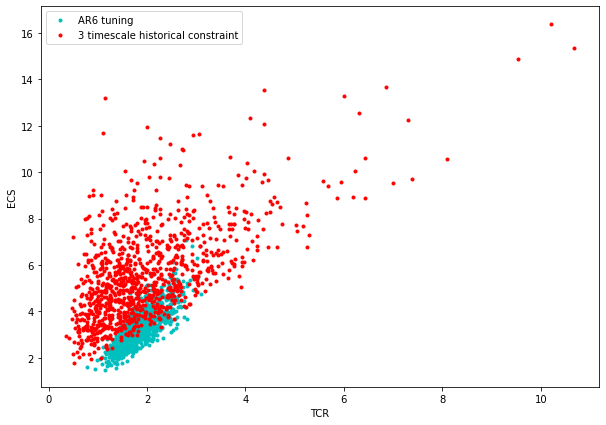

In [17]:
plt.figure(figsize=(10,7))
p1=plt.plot(tcrecs[:,0],tcrecs[:,1],'c.')
p2=plt.plot(tcr_q,ecs_q,'r.')
plt.ylabel('ECS')
plt.xlabel('TCR')
plt.legend((p1[0],p2[0]),['AR6 tuning','3 timescale historical constraint'])

Filter PPE

#constrain MC distribution

In [18]:

#Run SSP3 basline ensemble to calibrate plausible FAIR parameters (Extended)
Tens3 = np.zeros((736,samples))
Fens3 = np.zeros((736,samples))
Cens3 = np.zeros((736,31,samples))

for i in range(samples):
    Cens3[:,:,i], _, Tens3[:,i] = fair.forward.fair_scm(emissions=ssp370.Emissions.emissions,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        scale = F_scale[i,:],
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])  

/Users/CDKoven/miniforge3/lib/python3.9/site-packages/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))
/Users/CDKoven/miniforge3/lib/python3.9/site-packages/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in multiply
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


In [19]:
#Run SSP3 basline ensemble to calibrate plausible FAIR parameters (Chris original)
Tens2 = np.zeros((736,samples))
Fens2 = np.zeros((736,samples))
Cens2 = np.zeros((736,31,samples))

for i in range(samples):
    Cens2[:,:,i], _, Tens2[:,i] = fair.forward.fair_scm(emissions=ssp370.Emissions.emissions,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = tcrecs[i,:],
                        scale = F_scale[i,:],
                        F2x = 3.71*F_scale[i,0])   # scale F2x with the CO2 scaling factor for consistency


In [20]:
#Follow Smith et al to constrain output based on CW
try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen
    
from fair.tools.constrain import hist_temp

# load up Cowtan and Way data remotely
url = 'http://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_annual_v2_0_0.txt'
response = urlopen(url)

CW = np.loadtxt(response)
constrained = np.zeros(samples, dtype=bool)
constrained_org = np.zeros(samples, dtype=bool)


for i in range(samples):
    # we use observed trend from 1880 to 2016
    constrained[i], _, _, _, _ = hist_temp(CW[30:167,1], Tens3[1880-1765:2017-1765,i], CW[30:167,0])
    constrained_org[i], _, _, _, _ = hist_temp(CW[30:167,1], Tens2[1880-1765:2017-1765,i], CW[30:167,0])
   
    
# How many ensemble members passed the constraint?
print('%d ensemble members passed historical constraint' % np.sum(constrained))

206 ensemble members passed historical constraint


Text(0, 0.5, 'ppm')

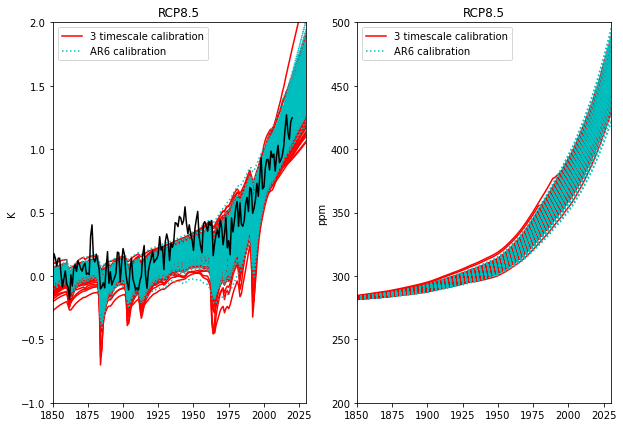

In [21]:
# Plot constrained baseline ensemble
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(121)
p1=ax1.plot(rcp85.Emissions.year, Tens3[:,constrained],'r');
p2=ax1.plot(rcp85.Emissions.year, Tens2[:,constrained_org],'c:');
plt.legend((p1[0],p2[0]),['3 timescale calibration','AR6 calibration'])
plt.title('RCP8.5')
plt.plot(CW[:,0],CW[:,1]+0.4,'k')
plt.xlim(1850,2030)
plt.ylim(-1,2)
plt.ylabel('K')


ax2 = fig.add_subplot(122)
p1=ax2.plot(rcp85.Emissions.year, Cens3[:,0,constrained],'r');
p2=ax2.plot(rcp85.Emissions.year, Cens2[:,0,constrained_org],'c:');
plt.legend((p1[0],p2[0]),['3 timescale calibration','AR6 calibration'])
plt.title('RCP8.5')
plt.xlim(1850,2030)
plt.ylim(200,500)
plt.ylabel('ppm')

In [22]:
isgd=[i for i, x in enumerate(constrained) if x]
isgd_org=[i for i, x in enumerate(constrained_org) if x]

#explore ZEC distribution

In [23]:
Tz = np.zeros((170,np.sum(constrained_org)))*np.nan
T4o = np.zeros((3000,np.sum(constrained_org)))*np.nan
ZEC50o=np.zeros((np.sum(constrained_org)))*np.nan
ZEC100o=np.zeros((np.sum(constrained_org)))*np.nan
TCREo=np.zeros((np.sum(constrained_org)))*np.nan


#Run classic consrained ensemble

for i,j in enumerate(isgd_org):
    _, _, Tz[:,i],_,ZEC50o[i],ZEC100o[i],TCREo[i] = get_zec(r0 = r0[j],
                        rc = rc[j],
                        rt = rt[j],
                        tcrecs = tcrecs[j,:])   # scale F2x with the CO2 scaling factor for consistency
    Tz[:,i]=Tz[:,i]-Tz[70,i]
    _,_,T4o[:,i]=get_4x(r0 = r0[j],
                        rc = rc[j],
                        rt = rt[j],
                        tcrecs = tcrecs[j,:]
                        ) 

/Users/CDKoven/miniforge3/lib/python3.9/site-packages/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))
/Users/CDKoven/miniforge3/lib/python3.9/site-packages/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in multiply
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


In [24]:
Tn = np.zeros((170,np.sum(constrained)))*np.nan
Fn = np.zeros((2,np.sum(constrained)))*np.nan
T4 = np.zeros((3000,np.sum(constrained)))*np.nan
ZEC50=np.zeros((np.sum(constrained)))*np.nan
ZEC100=np.zeros((np.sum(constrained)))*np.nan
TCRE=np.zeros((np.sum(constrained)))*np.nan

#Run extended consrained ensemble

for i,j in enumerate(isgd):
    _, _, Tn[:,i],_,ZEC50[i],ZEC100[i],TCRE[i] = get_zec(r0 = r0[j],
                        rc = rc[j],
                        rt = rt[j],
                        tcrecs = None,
                        tau=tau[j,:],
                        q=q[j,:],
                        d=d[j,:]
                        )   # scale F2x with the CO2 scaling factor for consistency
    Fn[:,i]=get_frdln(r0 = r0[j],
                        rc = rc[j],
                        rt = rt[j],
                        tcrecs = None,
                        tau=tau[j,:],
                        q=q[j,:],
                        d=d[j,:]
                        )
    _,_,T4[:,i]=get_4x(r0 = r0[j],
                        rc = rc[j],
                        rt = rt[j],
                        tcrecs = None,
                        tau=tau[j,:],
                        q=q[j,:],
                        d=d[j,:]
                        ) 
    TCR=Tn[70,i]
    Tn[:,i]=Tn[:,i]-TCR

1

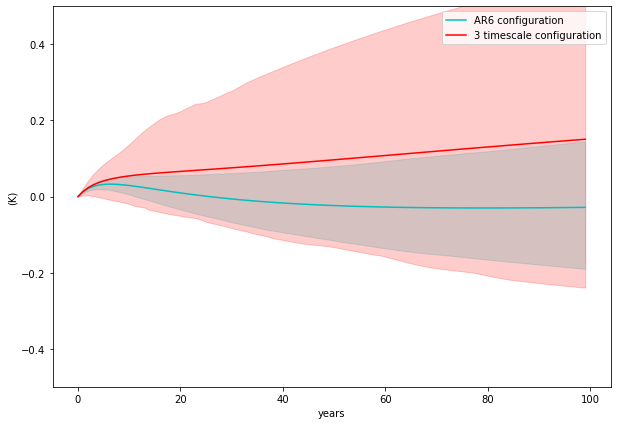

In [25]:
fig = plt.figure(figsize=(10,7))

plt.fill_between(np.arange(0,100),np.percentile(Tz[70:],10,axis=1),np.percentile(Tz[70:],90,axis=1),alpha = 0.2, color = 'c')
p1=plt.plot(np.arange(0,100),np.mean(Tz[70:],axis=1),color='c')

plt.fill_between(np.arange(0,100),np.nanpercentile(Tn[70:],10,axis=1),np.nanpercentile(Tn[70:],90,axis=1),alpha = 0.2, color = 'r')
p2=plt.plot(np.arange(0,100),np.nanmean(Tn[70:],axis=1),color='r')
#plt.plot(Tz[140:],'c')
#plt.plot(Tn[140:],'r',alpha=0.3)
plt.ylabel('(K)')
plt.xlabel('years')
plt.ylim([-.5,.5])
plt.legend((p1[0],p2[0]),['AR6 configuration','3 timescale configuration'])
1

#Explore sensitivity of response of default FaIR to blip timescale

In [26]:
#t_blip=np.arange(25,300,50)

t_blip=np.array([30.,45.,65,100.,150.])

Cs = np.zeros((3000,len(t_blip)))*np.nan
Fs = np.zeros((3000,len(t_blip)))*np.nan
Ts = np.zeros((3000,len(t_blip)))*np.nan
Es = np.zeros((3000,len(t_blip)))*np.nan


#Run extended consrained ensemble

for i,j in enumerate(t_blip):

    Cs[:,i],Fs[:,i],Ts[:,i],Es[:,i]=charlie_blip(tb=j) 

(0.0, 600.0)

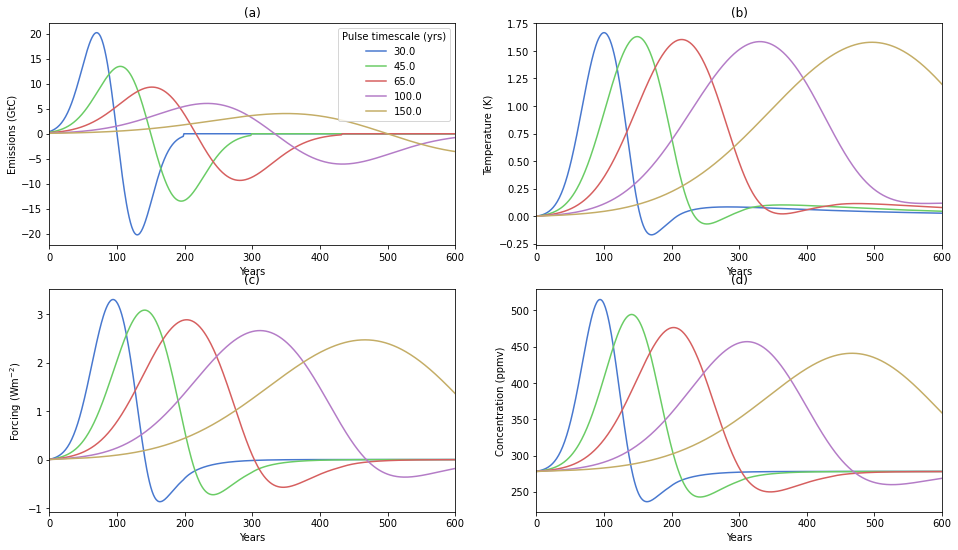

In [27]:
max_time= 600

fig, ax = plt.subplots(2, 2)
p1=ax[0,0].plot(Es)
ax[0,0].set_title('(a)')
ax[0,0].set_ylabel('Emissions (GtC)')
ax[0,0].set_xlabel('Years')
ax[0,0].set_xlim(0,max_time)
ax[0,0].legend(p1,t_blip,title="Pulse timescale (yrs)",loc=1)

ax[0,1].plot(Ts)
ax[0,1].set_title('(b)')
ax[0,1].set_ylabel('Temperature (K)')
ax[0,1].set_xlabel('Years')
ax[0,1].set_xlim(0,max_time)

ax[1,0].plot(Fs)
ax[1,0].set_title('(c)')
ax[1,0].set_ylabel('Forcing (Wm$^{-2}$)')
ax[1,0].set_xlabel('Years')
ax[1,0].set_xlim(0,max_time)

ax[1,1].plot(Cs)
ax[1,1].set_title('(d)')
ax[1,1].set_ylabel('Concentration (ppmv)')
ax[1,1].set_xlabel('Years')
ax[1,1].set_xlim(0,max_time)


Explore sensitivty to blip amplitude

In [28]:
a_blip=np.arange(1000,7000,1000)

Csa = np.zeros((3000,len(a_blip)))*np.nan
Fsa = np.zeros((3000,len(a_blip)))*np.nan
Tsa = np.zeros((3000,len(a_blip)))*np.nan
Esa = np.zeros((3000,len(a_blip)))*np.nan


#Run extended consrained ensemble

for i,j in enumerate(a_blip):

    Csa[:,i],Fsa[:,i],Tsa[:,i],Esa[:,i]=charlie_blip(ta=j) 

(0.0, 1000.0)

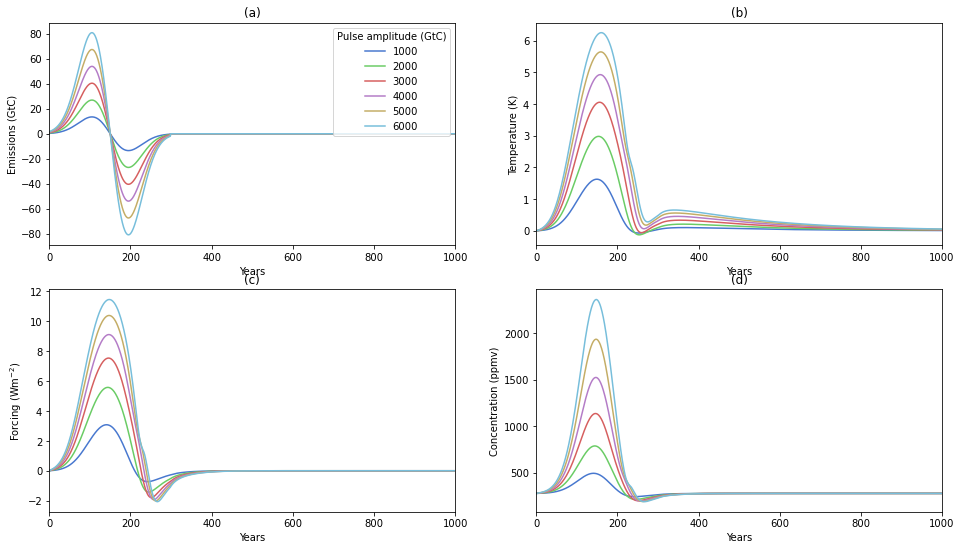

In [29]:
fig, ax = plt.subplots(2, 2)
p1=ax[0,0].plot(Esa)
ax[0,0].set_title('(a)')
ax[0,0].set_ylabel('Emissions (GtC)')
ax[0,0].set_xlabel('Years')
ax[0,0].set_xlim(0,1000)
ax[0,0].legend(p1,a_blip,title="Pulse amplitude (GtC)",loc=1)

ax[0,1].plot(Tsa)
ax[0,1].set_title('(b)')
ax[0,1].set_ylabel('Temperature (K)')
ax[0,1].set_xlabel('Years')
ax[0,1].set_xlim(0,1000)

ax[1,0].plot(Fsa)
ax[1,0].set_title('(c)')
ax[1,0].set_ylabel('Forcing (Wm$^{-2}$)')
ax[1,0].set_xlabel('Years')
ax[1,0].set_xlim(0,1000)

ax[1,1].plot(Csa)
ax[1,1].set_title('(d)')
ax[1,1].set_ylabel('Concentration (ppmv)')
ax[1,1].set_xlabel('Years')
ax[1,1].set_xlim(0,1000)


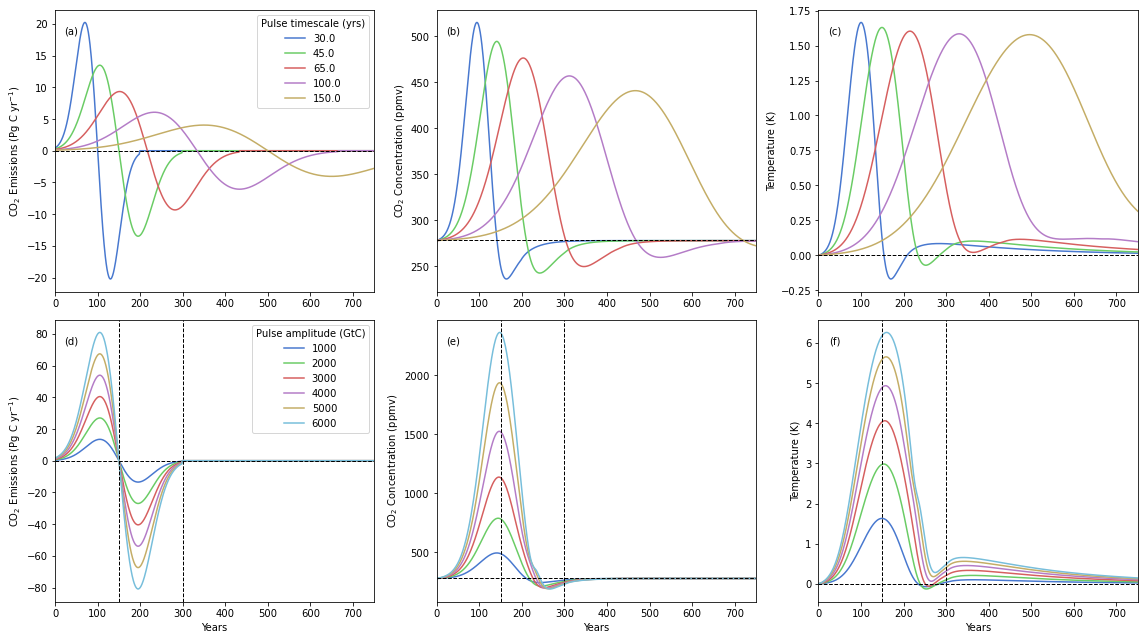

In [30]:

max_time= 750

fig, ax = plt.subplots(2, 3)
#plt.rcParams.update({'font.size': 1})

#fig.subplots_adjust(left=0.05)

p1=ax[0,0].plot(Es)
#ax[0,0].set_title('(a)')
ax[0,0].set_ylabel('CO$_2$ Emissions (Pg C yr$^{-1}$)')
#ax[0,0].set_xlabel('Years')
ax[0,0].set_xlim(0,max_time)
ax[0,0].legend(p1,t_blip,title="Pulse timescale (yrs)",loc='upper right')
#ax[0,0].axvline(150., color='black', linestyle='--', linewidth=1)
#ax[0,0].axvline(300., color='black', linestyle='--', linewidth=1)
ax[0,0].text(0.05, 0.925,'(a)', ha='center', va='center', transform=ax[0,0].transAxes)
ax[0,0].axhline(0., color='black', linestyle='--', linewidth=1)



ax[0,1].plot(Cs)
#ax[0,1].set_title('(c)')
ax[0,1].set_ylabel('CO$_2$ Concentration (ppmv)')
#ax[0,1].set_xlabel('Years')
ax[0,1].set_xlim(0,max_time)
#ax[0,1].legend(p1,t_blip,title="Pulse timescale (yrs)",loc=1)
#ax[0,1].axvline(150., color='black', linestyle='--', linewidth=1)
#ax[0,1].axvline(300., color='black', linestyle='--', linewidth=1)
ax[0,1].text(0.05, 0.925,'(b)', ha='center', va='center', transform=ax[0,1].transAxes)
ax[0,1].axhline([Cs[0,0]], color='black', linestyle='--', linewidth=1)



ax[0,2].plot(Ts)
#ax[0,2].set_title('(b)')
ax[0,2].set_ylabel('Temperature (K)')
#ax[0,2].set_xlabel('Years')
ax[0,2].set_xlim(0,max_time)
#ax[0,2].legend(p1,t_blip,title="Pulse timescale (yrs)",loc=1)
#ax[0,2].axvline(150., color='black', linestyle='--', linewidth=1)
#ax[0,2].axvline(300., color='black', linestyle='--', linewidth=1)
ax[0,2].text(0.05, 0.925,'(c)', ha='center', va='center', transform=ax[0,2].transAxes)
ax[0,2].axhline(0., color='black', linestyle='--', linewidth=1)



p1=ax[1,0].plot(Esa)
#ax[1,0].set_title('(a)')
ax[1,0].set_ylabel('CO$_2$ Emissions (Pg C yr$^{-1}$)')
ax[1,0].set_xlabel('Years')
ax[1,0].set_xlim(0,max_time)
ax[1,0].legend(p1,a_blip,title="Pulse amplitude (GtC)",loc='upper right')
ax[1,0].axvline(150., color='black', linestyle='--', linewidth=1)
ax[1,0].axvline(300., color='black', linestyle='--', linewidth=1)
ax[1,0].text(0.05, 0.925,'(d)', ha='center', va='center', transform=ax[1,0].transAxes)
ax[1,0].axhline(0., color='black', linestyle='--', linewidth=1)




ax[1,1].plot(Csa)
#ax[1,1].set_title('(d)')
ax[1,1].set_ylabel('CO$_2$ Concentration (ppmv)')
ax[1,1].set_xlabel('Years')
ax[1,1].set_xlim(0,max_time)
#ax[1,1].legend(p1,a_blip,title="Pulse amplitude (GtC)",loc=1)
ax[1,1].axvline(150., color='black', linestyle='--', linewidth=1)
ax[1,1].axvline(300., color='black', linestyle='--', linewidth=1)
ax[1,1].text(0.05, 0.925,'(e)', ha='center', va='center', transform=ax[1,1].transAxes)
ax[1,1].axhline(Csa[0,0], color='black', linestyle='--', linewidth=1)




ax[1,2].plot(Tsa)
#ax[1,2].set_title('(b)')
ax[1,2].set_ylabel('Temperature (K)')
ax[1,2].set_xlabel('Years')
ax[1,2].set_xlim(0,max_time)
#ax[1,2].legend(p1,a_blip,title="Pulse amplitude (GtC)",loc=1)
ax[1,2].axvline(150., color='black', linestyle='--', linewidth=1)
ax[1,2].axvline(300., color='black', linestyle='--', linewidth=1)
ax[1,2].text(0.05, 0.925,'(f)', ha='center', va='center', transform=ax[1,2].transAxes)
ax[1,2].axhline(0., color='black', linestyle='--', linewidth=1)




fig.tight_layout()

plt.savefig('pulse_wifth_amp_fig.pdf')
plt.savefig('pulse_wifth_amp_fig.png')


lag between cumulative emissions and peak warming [ 0  4  7  9 10 11]


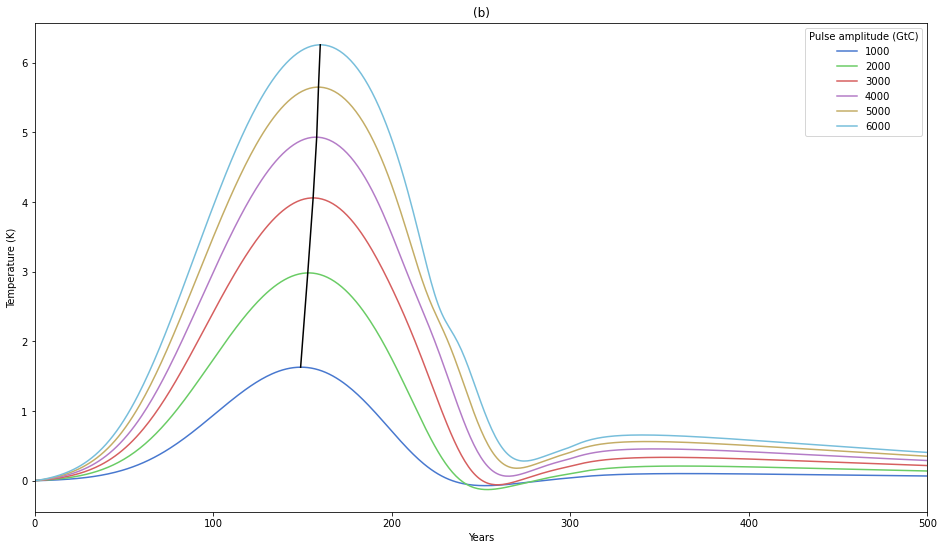

In [31]:
plt.plot(Tsa)
plt.plot(Tsa.argmax(axis=0), Tsa.max(axis=0), color='black')
plt.title('(b)')
plt.ylabel('Temperature (K)')
plt.xlabel('Years')
plt.xlim(0,500)
plt.legend(p1,a_blip,title="Pulse amplitude (GtC)",loc=1)

print( 'lag between cumulative emissions and peak warming', Tsa.argmax(axis=0)-Esa.cumsum(axis=0).argmax(axis=0))

lag between cumulative emissions and peak CO2 concentrations [-8 -5 -3 -2 -2 -1]


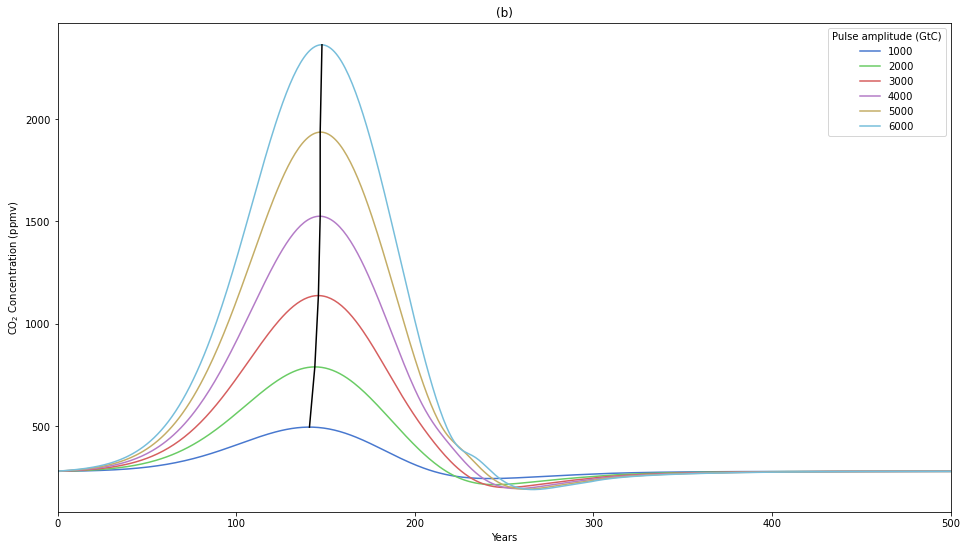

In [32]:
plt.plot(Csa)
plt.plot(Csa.argmax(axis=0), Csa.max(axis=0), color='black')
plt.title('(b)')
plt.ylabel('CO$_2$ Concentration (ppmv)')
plt.xlabel('Years')
plt.xlim(0,500)
plt.legend(p1,a_blip,title="Pulse amplitude (GtC)",loc=1)

print( 'lag between cumulative emissions and peak CO2 concentrations', Csa.argmax(axis=0) - Esa.cumsum(axis=0).argmax(axis=0))

#explore sensitivity of blip response (45 year timescale) to FaIR parameters

In [33]:
Cb = np.zeros((3000,np.sum(constrained)))*np.nan
Fb = np.zeros((3000,np.sum(constrained)))*np.nan
Tb = np.zeros((3000,np.sum(constrained)))*np.nan
t_mxt=np.zeros((np.sum(constrained)))
t_mx=np.zeros((np.sum(constrained)))

#Run extended consrained ensemble

for i,j in enumerate(isgd):

    Cb[:,i],Fb[:,i],Tb[:,i],_=charlie_blip(r0 = r0[j],
                        rc = rc[j],
                        rt = rt[j],
                        tcrecs = None,
                        tau=tau[j,:],
                        q=q[j,:],
                        d=d[j,:]
                        ) 
    t_tmp=np.argmax(Tb[:,i])
    #do a quadratic fit around maximum to get estimate of peak warming time
    z = np.polyfit([-1,0,1], Tb[tuple((t_tmp+[-1,0,1]).astype(int)),i], 2)
    xmax=z[1]/(2*z[0])
    t_mxt[i]=t_tmp+xmax
    t_mx[i]=z[0]*np.square(xmax)+z[1]*xmax+z[2]
    

/Users/CDKoven/miniforge3/lib/python3.9/site-packages/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))
/Users/CDKoven/miniforge3/lib/python3.9/site-packages/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in multiply
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


Plot ensemble range

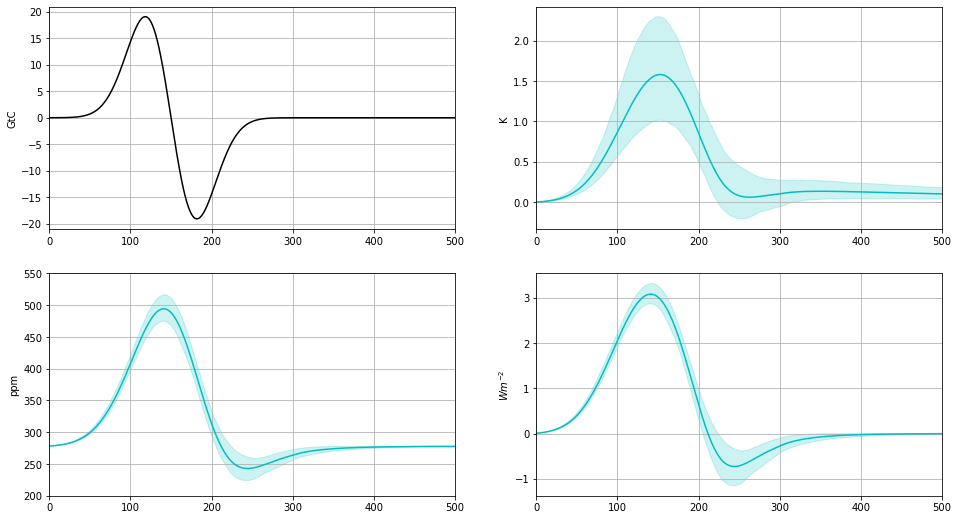

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2)

nt=3000
emms=1000*2*(-(np.arange(0,nt)-150))/np.square(45)*np.exp(-(np.square((np.arange(0,nt)-150)/45)))




ax[0,0].plot(np.arange(0,3000),emms,color='k')
ax[0,0].set_xlim([0,500])
ax[0,0].set_ylabel('GtC')
ax[0,0].grid()

ax[0,1].fill_between(np.arange(0,3000),np.percentile(Tb[:],10,axis=1),np.percentile(Tb[:],90,axis=1),alpha = 0.2, color = 'c')
ax[0,1].plot(np.arange(0,3000),np.mean(Tb[:],axis=1),color='c')
ax[0,1].set_xlim([0,500])
ax[0,1].set_ylabel('K')
ax[0,1].grid()


ax[1,0].fill_between(np.arange(0,3000),np.percentile(Cb[:],10,axis=1),np.percentile(Cb[:],90,axis=1),alpha = 0.2, color = 'c')
ax[1,0].plot(np.arange(0,3000),np.mean(Cb[:],axis=1),color='c')
ax[1,0].set_xlim([0,500])
ax[1,0].set_ylim([200,550])

ax[1,0].set_ylabel('ppm')
ax[1,0].grid()

ax[1,1].fill_between(np.arange(0,3000),np.percentile(Fb[:],10,axis=1),np.percentile(Fb[:],90,axis=1),alpha = 0.2, color = 'c')
ax[1,1].plot(np.arange(0,3000),np.mean(Fb[:],axis=1),color='c')
ax[1,1].set_xlim([0,500])


ax[1,1].set_ylabel(r'$Wm^{-2}$')
ax[1,1].grid()



Look at the cumulative emissions relationship

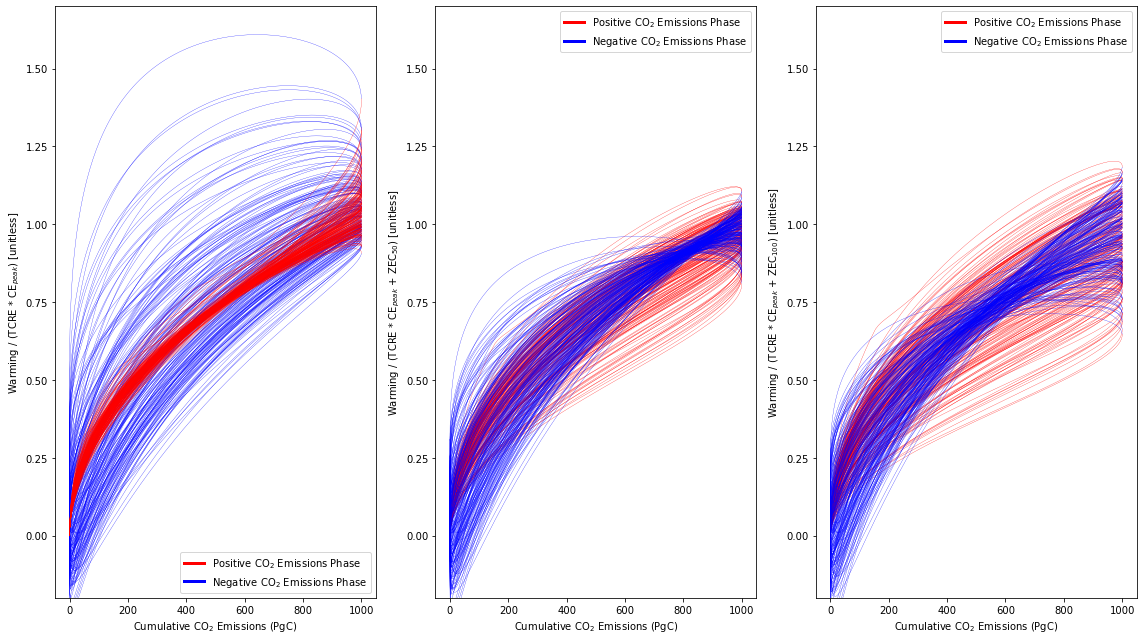

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=3)

#fig.set_size_inches(10, 12)

lw = 0.25 # line width

ax[0].plot(np.cumsum(emms)[150:],Tb[150:]/(TCRE), color='blue', linewidth=lw)
ax[0].plot(np.cumsum(emms)[0:151],Tb[0:151]/(TCRE), color='red', linewidth=lw)
ax[0].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='red', linewidth=3, label='Positive CO$_2$ Emissions Phase')
ax[0].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='blue', linewidth=3, label='Negative CO$_2$ Emissions Phase')
ax[0].set_ylabel('Warming / (TCRE * CE$_{peak}$) [unitless]')
ax[0].set_xlabel('Cumulative CO$_2$ Emissions (PgC)')
ax[0].set_ylim([-0.2,1.7])
ax[0].legend()

ax[2].plot(np.cumsum(emms)[0:151],Tb[0:151]/(TCRE+ZEC100), color='red', linewidth=lw)
ax[2].plot(np.cumsum(emms)[150:],Tb[150:]/(TCRE+ZEC100), color='blue', linewidth=lw)
ax[2].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='red', linewidth=3, label='Positive CO$_2$ Emissions Phase')
ax[2].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='blue', linewidth=3, label='Negative CO$_2$ Emissions Phase')
ax[2].set_ylabel('Warming / (TCRE * CE$_{peak}$ + ZEC$_{100}$) [unitless]')
ax[2].set_xlabel('Cumulative CO$_2$ Emissions (PgC)')
ax[2].set_ylim([-0.2,1.7])
ax[2].legend()

ax[1].plot(np.cumsum(emms)[0:151],Tb[0:151]/(TCRE+ZEC50), color='red', linewidth=lw)
ax[1].plot(np.cumsum(emms)[150:],Tb[150:]/(TCRE+ZEC50), color='blue', linewidth=lw)
ax[1].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='red', linewidth=3, label='Positive CO$_2$ Emissions Phase')
ax[1].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='blue', linewidth=3, label='Negative CO$_2$ Emissions Phase')
ax[1].set_ylabel('Warming / (TCRE * CE$_{peak}$ + ZEC$_{50}$) [unitless]')
ax[1].set_xlabel('Cumulative CO$_2$ Emissions (PgC)')
ax[1].set_ylim([-0.2,1.7])
ax[1].legend()

fig.tight_layout()

plt.savefig('Tnorm_vs_CE.pdf')
plt.savefig('Tnorm_vs_CE.png')


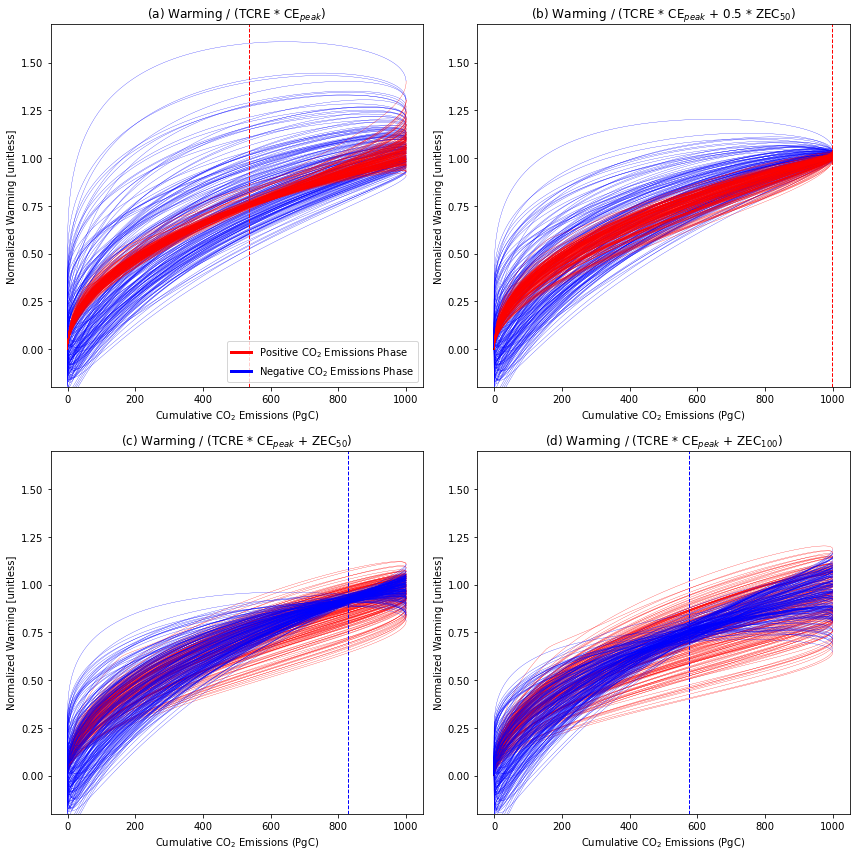

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=2)

fig.set_size_inches(12, 12)

lw = 0.25 # line width

ax[0,0].plot(np.cumsum(emms)[150:],Tb[150:]/(TCRE), color='blue', linewidth=lw)
ax[0,0].plot(np.cumsum(emms)[0:151],Tb[0:151]/(TCRE), color='red', linewidth=lw)
ax[0,0].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='red', linewidth=3, label='Positive CO$_2$ Emissions Phase')
ax[0,0].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='blue', linewidth=3, label='Negative CO$_2$ Emissions Phase')
ax[0,0].set_title('(a) Warming / (TCRE * CE$_{peak}$)')
ax[0,0].set_ylabel('Normalized Warming [unitless]')
ax[0,0].set_xlabel('Cumulative CO$_2$ Emissions (PgC)')
ax[0,0].set_ylim([-0.2,1.7])
ax[0,0].legend()
#ax[0,0].text(0.05, 0.925,'(a)', ha='center', va='center', transform=ax[0,0].transAxes)
minspreadloc_tcre = np.argmin(np.std(Tb/TCRE, axis=1)[100:300])
ax[0,0].axvline(np.cumsum(emms)[minspreadloc_tcre+100], color='red', linestyle='--', linewidth=1)


ax[1,1].plot(np.cumsum(emms)[0:151],Tb[0:151]/(TCRE+ZEC100), color='red', linewidth=lw)
ax[1,1].plot(np.cumsum(emms)[150:],Tb[150:]/(TCRE+ZEC100), color='blue', linewidth=lw)
ax[1,1].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='red', linewidth=3, label='Positive CO$_2$ Emissions Phase')
ax[1,1].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='blue', linewidth=3, label='Negative CO$_2$ Emissions Phase')
ax[1,1].set_title('(d) Warming / (TCRE * CE$_{peak}$ + ZEC$_{100}$)')
ax[1,1].set_ylabel('Normalized Warming [unitless]')
ax[1,1].set_xlabel('Cumulative CO$_2$ Emissions (PgC)')
ax[1,1].set_ylim([-0.2,1.7])
#ax[1,1].legend(loc='upper right')
#ax[1,1].text(0.05, 0.925,'(d)', ha='center', va='center', transform=ax[1,1].transAxes)
minspreadloc_tcrezec100 = np.argmin(np.std(Tb/(TCRE+ZEC100), axis=1)[100:300])
ax[1,1].axvline(np.cumsum(emms)[minspreadloc_tcrezec100+100], color='blue', linestyle='--', linewidth=1)



ax[0,1].plot(np.cumsum(emms)[150:],Tb[150:]/(TCRE+ZEC50*0.5), color='blue', linewidth=lw)
ax[0,1].plot(np.cumsum(emms)[0:151],Tb[0:151]/(TCRE+ZEC50*0.5), color='red', linewidth=lw)
ax[0,1].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='red', linewidth=3, label='Positive CO$_2$ Emissions Phase')
ax[0,1].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='blue', linewidth=3, label='Negative CO$_2$ Emissions Phase')
ax[0,1].set_title('(b) Warming / (TCRE * CE$_{peak}$ + 0.5 * ZEC$_{50}$)')
ax[0,1].set_ylabel('Normalized Warming [unitless]')
ax[0,1].set_xlabel('Cumulative CO$_2$ Emissions (PgC)')
ax[0,1].set_ylim([-0.2,1.7])
#ax[0,1].legend()
#ax[0,1].text(0.05, 0.925,'(b)', ha='center', va='center', transform=ax[0,1].transAxes)
minspreadloc_tcrehalfzec = np.argmin(np.std(Tb/(TCRE+ZEC50*0.5), axis=1)[100:300])
ax[0,1].axvline(np.cumsum(emms)[minspreadloc_tcrehalfzec+100], color='red', linestyle='--', linewidth=1)



ax[1,0].plot(np.cumsum(emms)[0:151],Tb[0:151]/(TCRE+ZEC50), color='red', linewidth=lw)
ax[1,0].plot(np.cumsum(emms)[150:],Tb[150:]/(TCRE+ZEC50), color='blue', linewidth=lw)
ax[1,0].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='red', linewidth=3, label='Positive CO$_2$ Emissions Phase')
ax[1,0].plot(np.ma.masked_all(2),np.ma.masked_all(2), color='blue', linewidth=3, label='Negative CO$_2$ Emissions Phase')
ax[1,0].set_title('(c) Warming / (TCRE * CE$_{peak}$ + ZEC$_{50}$)')
ax[1,0].set_ylabel('Normalized Warming [unitless]')
ax[1,0].set_xlabel('Cumulative CO$_2$ Emissions (PgC)')
ax[1,0].set_ylim([-0.2,1.7])
#ax[1,0].legend()
#ax[1,0].text(0.05, 0.925,'(c)', ha='center', va='center', transform=ax[1,0].transAxes)
minspreadloc_tcrezec50 = np.argmin(np.std(Tb/(TCRE+ZEC50), axis=1)[100:300])
ax[1,0].axvline(np.cumsum(emms)[minspreadloc_tcrezec50+100], color='blue', linestyle='--', linewidth=1)




fig.tight_layout()

plt.savefig('Tnorm_vs_CE_4panel.pdf')
plt.savefig('Tnorm_vs_CE_4panel.png')



In [37]:
minspreadloc_tcrehalfzec+100

148

#Look at peak warming/ZEC relationships

In [38]:
t_aft=Tb[300,:]

Text(0, 0.5, 'Post-pulse warming, yr 300 (K)')

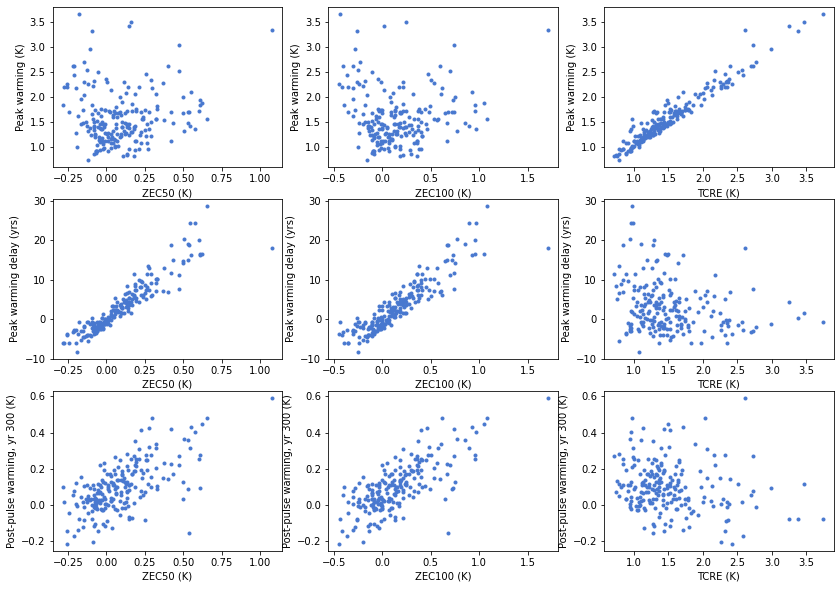

In [39]:
fig, ax = plt.subplots(nrows=3, ncols=3)

fig = plt.gcf()
fig.set_size_inches(14, 10)


ax[0,0].plot(ZEC50,t_mx,'.')
ax[0,0].set_xlabel('ZEC50 (K)')
ax[0,0].set_ylabel('Peak warming (K)')

ax[0,1].plot(ZEC100,t_mx,'.')
ax[0,1].set_xlabel('ZEC100 (K)')
ax[0,1].set_ylabel('Peak warming (K)')

ax[0,2].plot(TCRE,t_mx,'.')
ax[0,2].set_xlabel('TCRE (K)')
ax[0,2].set_ylabel('Peak warming (K)')

ax[1,0].plot(ZEC50,t_mxt-150,'.')
ax[1,0].set_xlabel('ZEC50 (K)')
ax[1,0].set_ylabel('Peak warming delay (yrs)')

ax[1,1].plot(ZEC100,t_mxt-150,'.')
ax[1,1].set_xlabel('ZEC100 (K)')
ax[1,1].set_ylabel('Peak warming delay (yrs)')

ax[1,2].plot(TCRE,t_mxt-150,'.')
ax[1,2].set_xlabel('TCRE (K)')
ax[1,2].set_ylabel('Peak warming delay (yrs)')

ax[2,0].plot(ZEC50,t_aft,'.')
ax[2,0].set_xlabel('ZEC50 (K)')
ax[2,0].set_ylabel('Post-pulse warming, yr 300 (K)')

ax[2,1].plot(ZEC100,t_aft,'.')
ax[2,1].set_xlabel('ZEC100 (K)')
ax[2,1].set_ylabel('Post-pulse warming, yr 300 (K)')

ax[2,2].plot(TCRE,t_aft,'.')
ax[2,2].set_xlabel('TCRE (K)')
ax[2,2].set_ylabel('Post-pulse warming, yr 300 (K)')


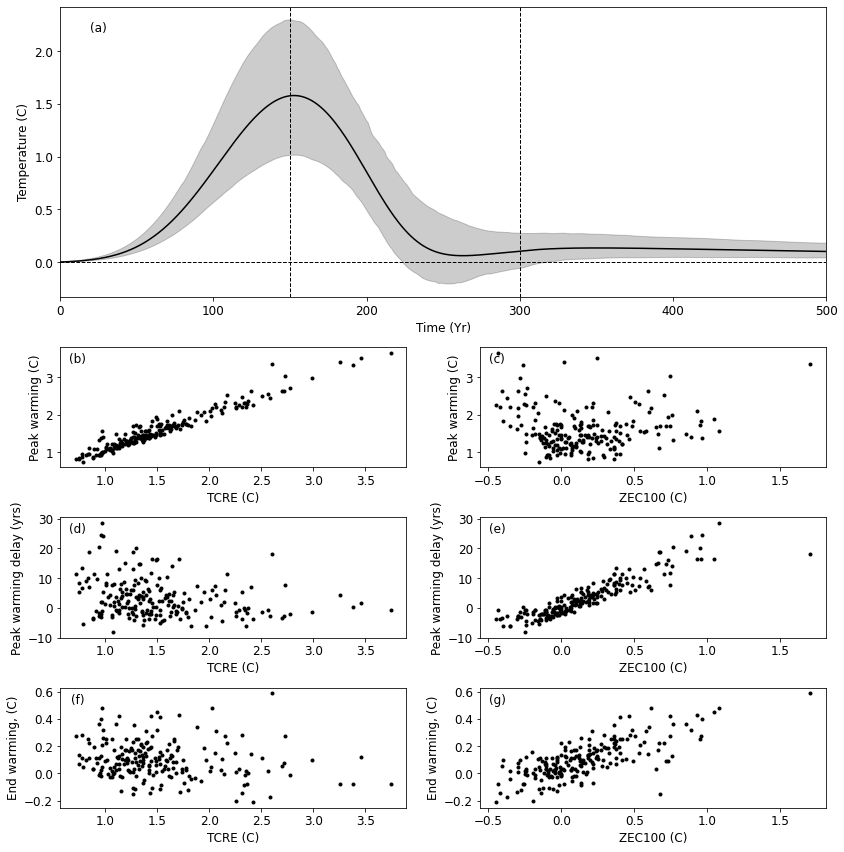

In [40]:
#fig, ax = plt.subplots(nrows=5, ncols=2)

fig = plt.gcf()
fig.set_size_inches(12, 12)

gs = fig.add_gridspec(5,2)
#fig.subplots_adjust(top=1.2)

plt.rcParams.update({'font.size': 12})

#plt.subplot(3, 1, 1)
ax1 = fig.add_subplot(gs[0:2,0:2])
ax1.fill_between(np.arange(0,3000),np.percentile(Tb[:],10,axis=1),np.percentile(Tb[:],90,axis=1),alpha = 0.2, color = 'black')
ax1.plot(np.arange(0,3000),np.mean(Tb[:],axis=1),color='black')
ax1.set_xlim([0,500])
ax1.set_ylabel('Temperature (C)')
ax1.set_xlabel('Time (Yr)')
#ax1.grid()
ax1.axvline(150., color='black', linestyle='--', linewidth=1)
ax1.axvline(300., color='black', linestyle='--', linewidth=1)
ax1.axhline(0., color='black', linestyle='--', linewidth=1)
ax1.text(0.05, 0.925,'(a)', ha='center', va='center', transform=ax1.transAxes)


ax3 = fig.add_subplot(gs[2, 0])
#plt.subplot(5, 2, 5)
ax3.plot(TCRE,t_mx,'.',c='black')
plt.xlabel('TCRE (C)')
plt.ylabel('Peak warming (C)')
ax3.text(0.05, 0.9,'(b)', ha='center', va='center', transform=ax3.transAxes)


ax2 = fig.add_subplot(gs[2, 1])
#plt.subplot(5, 2, 6)
ax2.plot(ZEC100,t_mx,'.',c='black')
plt.xlabel('ZEC100 (C)')
plt.ylabel('Peak warming (C)')
ax2.text(0.05, 0.9,'(c)', ha='center', va='center', transform=ax2.transAxes)


#plt.subplot(5, 2, 7)
ax5 = fig.add_subplot(gs[3, 0])
ax5.plot(TCRE,t_mxt-150,'.',c='black')
plt.xlabel('TCRE (C)')
plt.ylabel('Peak warming delay (yrs)')
ax5.text(0.05, 0.9,'(d)', ha='center', va='center', transform=ax5.transAxes)


#plt.subplot(5, 2, 8)
ax4 = fig.add_subplot(gs[3, 1])
ax4.plot(ZEC100,t_mxt-150,'.',c='black')
plt.xlabel('ZEC100 (C)')
plt.ylabel('Peak warming delay (yrs)')
ax4.text(0.05, 0.9,'(e)', ha='center', va='center', transform=ax4.transAxes)


#plt.subplot(5, 2, 9)
ax7 = fig.add_subplot(gs[4, 0])
ax7.plot(TCRE,t_aft,'.',c='black')
plt.xlabel('TCRE (C)')
plt.ylabel('End warming, (C)')
ax7.text(0.05, 0.9,'(f)', ha='center', va='center', transform=ax7.transAxes)


#plt.subplot(5, 2, 10)
ax6 = fig.add_subplot(gs[4, 1])
ax6.plot(ZEC100,t_aft,'.',c='black')
plt.xlabel('ZEC100 (C)')
plt.ylabel('End warming, (C)')
ax6.text(0.05, 0.9,'(g)', ha='center', va='center', transform=ax6.transAxes)



fig.tight_layout()

plt.savefig('fair_ppe_timeseries_scatterplots.pdf')
plt.savefig('fair_ppe_timeseries_scatterplots.png')



Does both TCRE and ZEC100 together give any improvement in prediction of end warming?


In [41]:
import statsmodels.api as sm

X = np.vstack((ZEC100,TCRE,np.ones(len(TCRE)))).T
y = t_aft

model = sm.OLS(y, X).fit()
ta_pred = model.predict(X) # make the predictions by the model


0.7370399175471836
0.736750441964093


Text(0, 0.5, 'End warming, (C)')

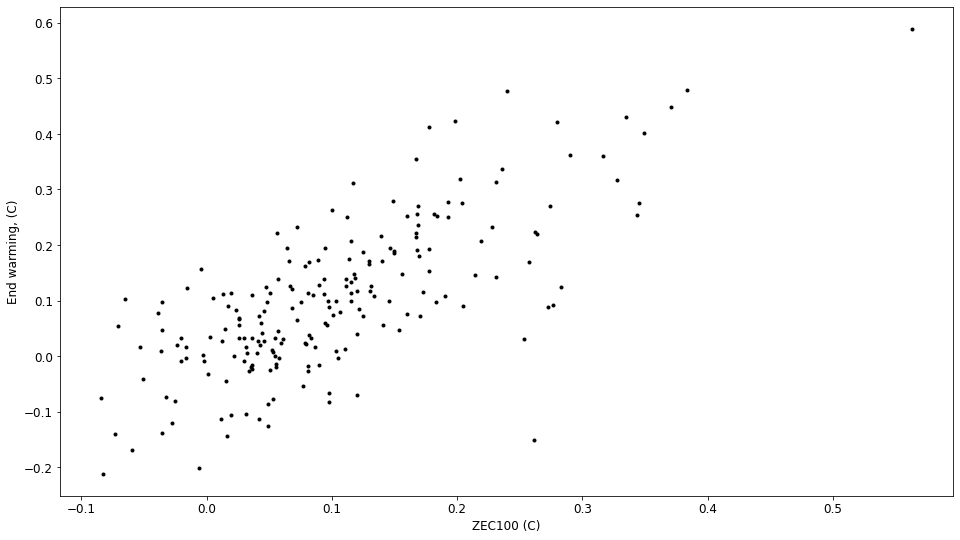

In [42]:
print(np.corrcoef(ta_pred,t_aft)[1,0])
print(np.corrcoef(ZEC100,t_aft)[1,0])
plt.plot(ta_pred,t_aft,'.',c='black')
plt.xlabel('ZEC100 (C)')
plt.ylabel('End warming, (C)')

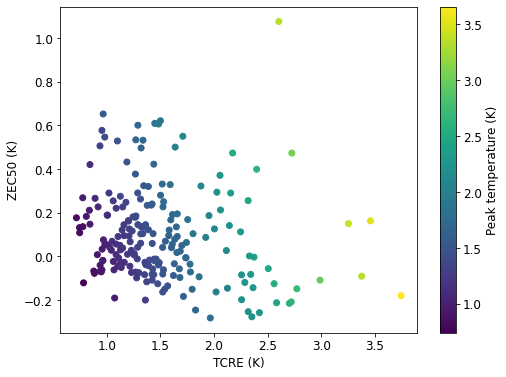

In [43]:
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.scatter(TCRE,ZEC50,c=t_mx)
plt.xlabel('TCRE (K)')
plt.ylabel('ZEC50 (K)')

cb=plt.colorbar()
cb.set_label('Peak temperature (K)')


# Build regression model to predict peak temperatures

In [44]:
pmat=np.vstack((r0,rc,rt,tau.T,q.T,d.T))
pmat[:,isgd].shape


(13, 206)

Text(0, 0.5, 'actual temperature peak (K)')

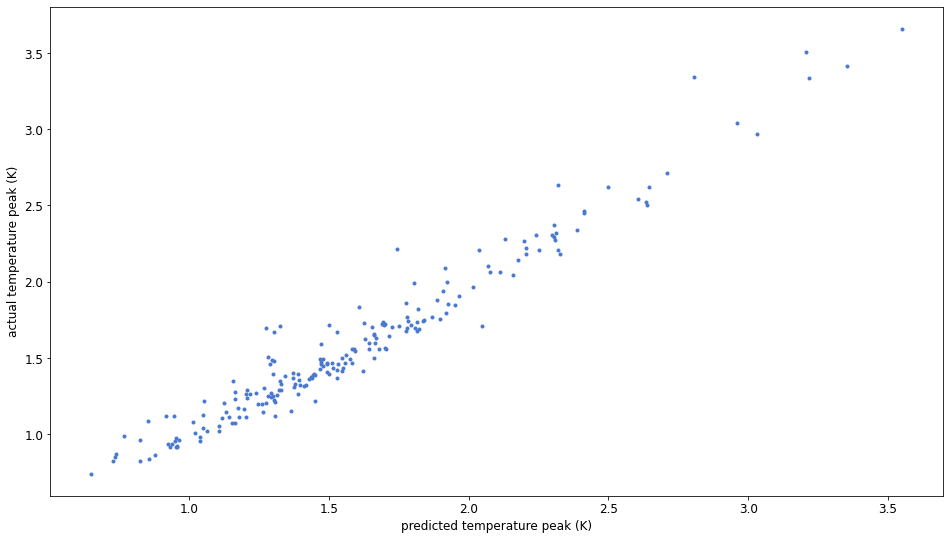

In [45]:

import pandas
from sklearn import linear_model

X = pmat[:,isgd].T
#ZEC = Tn[169,:]

regr = linear_model.LinearRegression()
regr.fit(X,t_mx)

#predict the CO2 emission of a car where the weight is 2300kg, and the volume is 1300cm3:
predictedCO2 = regr.predict(X)

plt.plot(predictedCO2,t_mx,'.')
plt.xlabel('predicted temperature peak (K)')
plt.ylabel('actual temperature peak (K)')


Plot correlation coefficients

Text(0, 0.5, 'Parameter Correlation coefficient T(max)')

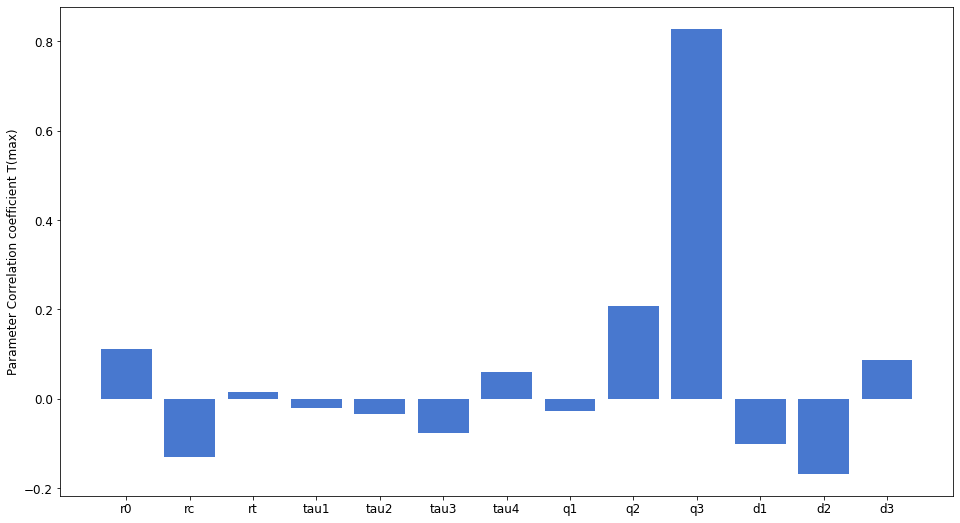

In [46]:
plt.bar(['r0','rc','rt','tau1','tau2','tau3','tau4','q1','q2','q3','d1','d2','d3'],np.corrcoef(X.T,t_mx)[:13,-1:].T[0])
plt.ylabel('Parameter Correlation coefficient T(max)')

Look at relationship between just fast timescale thermal sensitivty (q3) and peak temperature

Text(0.5, 0, 'Fast timescale sensitivity (K)')

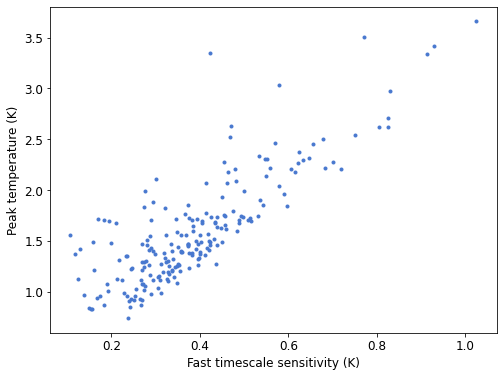

In [47]:
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.plot(q[isgd,2],t_mx,'.')
plt.ylabel('Peak temperature (K)')
plt.xlabel('Fast timescale sensitivity (K)')


# build regression model for time of peak warming vs net zero

In [48]:

X = pmat[:,isgd].T
ZEC = Tn[169,:]

regr = linear_model.LinearRegression()
regr.fit(X,t_mxt-120)

#predict the CO2 emission of a car where the weight is 2300kg, and the volume is 1300cm3:
predicted_nzt = regr.predict(X)


Text(0, 0.5, 'peak temp - net zero time (actual, yrs)')

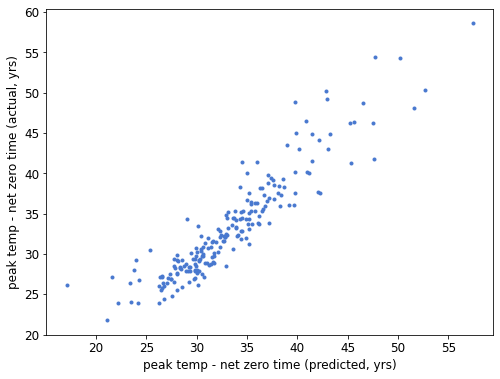

In [49]:
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.plot(predicted_nzt,t_mxt-120,'.')
plt.xlabel('peak temp - net zero time (predicted, yrs)')
plt.ylabel('peak temp - net zero time (actual, yrs)')

Text(0, 0.5, 'Parameter Correlation with peak temperature delay vs net zero time')

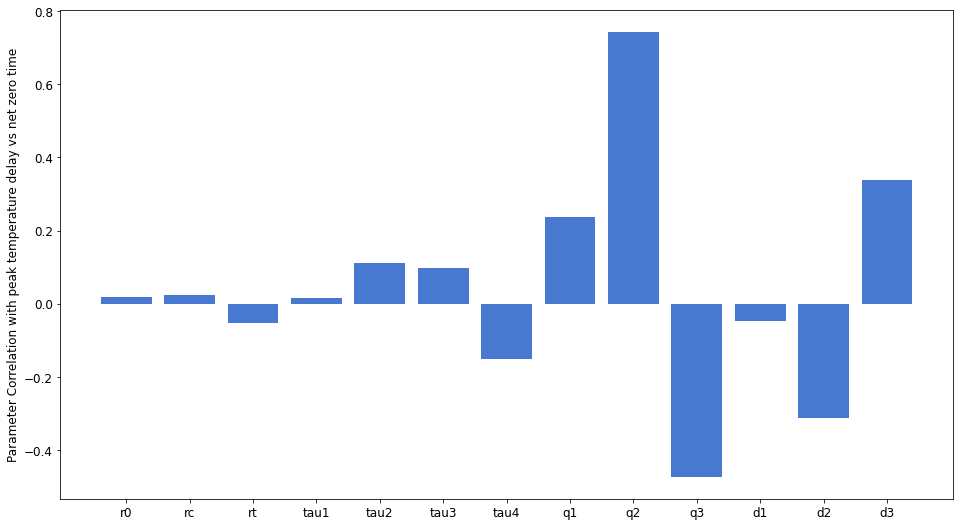

In [50]:
plt.bar(['r0','rc','rt','tau1','tau2','tau3','tau4','q1','q2','q3','d1','d2','d3'],np.corrcoef(X.T,t_mxt)[:13,-1:].T[0])
plt.ylabel('Parameter Correlation with peak temperature delay vs net zero time')

In [51]:
import pandas as pd
pdf=pd.DataFrame(X,columns=['r0','rc','rt','tau1','tau2','tau3','tau4','q1','q2','q3','d1','d2','d3'])
pdt=pdf.iloc[:,:10]
pdt=pdt.assign(ZEC=ZEC)
pdt

,r0,rc,rt,tau1,tau2,tau3,tau4,q1,q2,q3,ZEC
0,37.028145,0.018618,3.569340,9.255892e+05,528.055330,24.070110,1.517011,1.566118,0.265711,0.327271,0.336888
1,29.787020,0.017643,4.178105,5.267211e+05,131.563980,66.686172,2.910550,1.301296,0.162089,0.483144,-0.030330
2,28.947219,0.017004,4.435995,1.189392e+06,687.809413,37.890017,4.656645,0.628191,0.234580,0.514750,0.086570
3,32.652741,0.018984,4.217292,1.882668e+06,275.270055,103.272292,12.836389,0.325409,0.397818,0.252448,0.022505
4,35.865309,0.020555,3.960268,1.180624e+06,1539.502017,115.320621,3.816174,1.555398,0.246707,0.184200,0.293787
...,...,...,...,...,...,...,...,...,...,...,...
201,35.683052,0.018381,3.672310,4.811064e+05,397.525074,175.915150,3.621578,0.344848,0.236306,1.024597,-0.431713
202,33.258919,0.018941,4.177580,6.983526e+05,183.349025,42.350393,5.369307,0.660700,0.265535,0.397032,-0.107401
203,35.776620,0.018920,4.469209,1.520777e+06,101.873052,81.803814,5.505334,0.721916,0.314169,0.317028,0.065112
204,38.390434,0.018250,3.876702,2.045714e+06,541.001575,61.616404,6.952264,1.000163,0.329565,0.155061,0.358587
